### Project - 3
Jiachen Gong 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import lstsq
from scipy.linalg import solve
from scipy.optimize import minimize

### Lecture 7

#### Question 1

In [2]:
def jump(lambda_2, T,dt):
    # list for jump
    jump_index = []
    jump_resi = []
    # cnt - total time
    cnt = 0
    while True:
        # parameter = lambda*T, so scalar should be 1/lambda*T
        # jump_i is jump period for each step
        jump_i = np.random.exponential(1/(lambda_2*T))
        cnt += jump_i
        if cnt < T:
            # index of jumping position
            jump_index.append(int(cnt/dt))
            # residule of jumping point
            jump_resi.append(cnt%dt)
            # jump.append(cnt)
        else:
            break
    return jump_index, jump_resi

def Q_val(V_i, q, l, M):
    for i in range(M+1):
        if V_i[i]<q[i]*l[i]:
            return i
    return M

def prc(L0, V0, mu, sigma, gamma, alpha, r0, delta, eps, T, lambda_1, lambda_2, M,N):
    dt = T/M
    R = r0 + delta * lambda_2
    r = R/12
    n = T/12
    PMT = (L0 * r) / (1 - 1/(1+r)**n)
    a = PMT/r
    b = PMT/(r*(1+r)**n)
    c = 1+r
    beta = (eps-alpha)/T
    # M - x-axis stands for number of steps
    # N - y-axis number of paths
    payoff_list = []
    tao_list = []
    # time list
    T_list = np.arange(0,T+dt,dt)
    # print(len(T_list))
    # init qt and lt
    q = alpha+beta*T_list
    l = a-b-c**(12*T_list)
    # loop through each path
    for i in range(N):
        V_i = np.zeros(M+1)
        V_i[0] = V0
        jump_index, jump_resi = jump(lambda_1, T,dt)
        # loop through each step
        for j in range (1,M+1):
            Z = np.random.normal(0,1)
            # if there is a jump:
            if j-1 in jump_index:
                posi = jump_index.index(j-1)
                V_brfore_jump = V_i[j-1]+V_i[j-1]*(mu*dt+sigma*np.sqrt(jump_resi[posi])*Z)
                V_jump = V_brfore_jump*(1+gamma)
                V_i[j] = V_jump+V_jump*(mu*dt+sigma*np.sqrt(dt-jump_resi[posi])*Z)
            # if there is no jump
            else:
                V_i[j] = V_i[j-1]+V_i[j-1]*(mu*dt+sigma*np.sqrt(dt)*Z)
        # calculate Q and S
        Q = Q_val(V_i, q, l, M)
        S = int(np.random.exponential(1 / (lambda_2 * T)) / dt)
        # calculate tao
        tao = min(Q,S)
        # calculate payoff
        if tao>=T:
            continue
        if Q < S:
            payoff = np.maximum(l[Q]-V_i[Q]*eps,0)
        else:
            payoff = np.abs(l[S]-eps*V_i[S])
        payoff_list.append(payoff)
        tao_list.append(tao)
    
    default_rate = len(payoff_list)/N
    default_value = np.sum(payoff_list)/N
    tao_value = np.mean(tao_list)
    return default_value, default_rate, tao_value

In [3]:
# parameters 
L0 = 22000
V0 = 20000
mu = -0.1
sigma = 0.2
gamma = -0.4
alpha = 0.7
eps = 0.95
r0 = 0.055
delta = 0.25
lambda_2 = 0.4

M = 1000
N = 10000
T= 5
lambda_1 = 0.2

prc(L0, V0, mu, sigma, gamma, alpha, r0, delta, eps, T, lambda_1, lambda_2, M,N)

(339.4510748001387, 0.0639, 2.13302034428795)

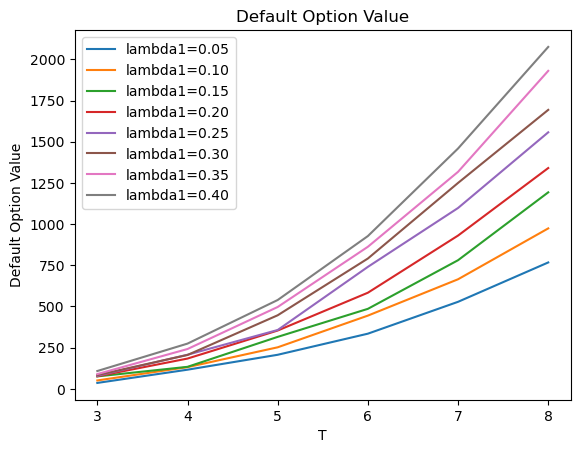

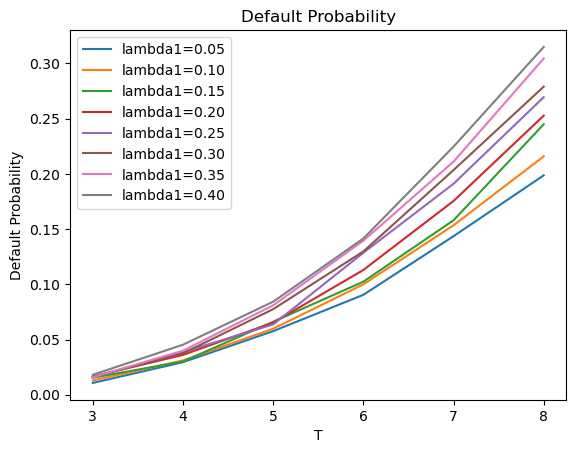

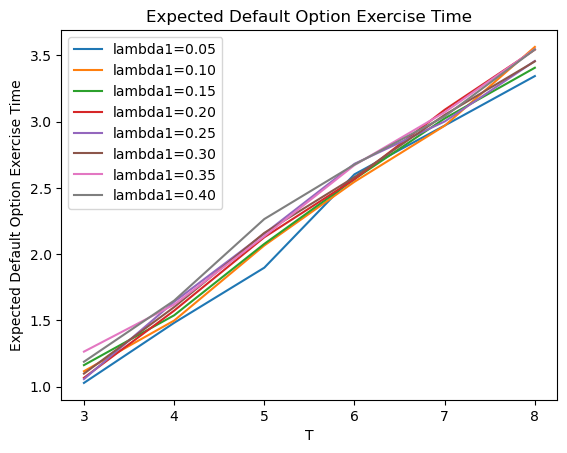

In [130]:
# parameters 
L0 = 22000
V0 = 20000
mu = -0.1
sigma = 0.2
gamma = -0.4
alpha = 0.7
eps = 0.95
r0 = 0.055
delta = 0.25
lambda_2 = 0.4

M = 1000

lambda_1_list = np.arange(0.05, 0.45, 0.05)
T_val = np.arange(3, 9, 1)


# nparray for results
default_val = np.zeros((len(lambda_1_list), len(T_val)))
default_p = np.zeros((len(lambda_1_list), len(T_val)))
taos = np.zeros((len(lambda_1_list), len(T_val)))

for i, lambda_1 in enumerate(lambda_1_list):
    for j, T in enumerate(T_val):
        default_val[i, j], default_p[i, j], taos[i, j] = prc(L0, V0, mu, sigma, gamma, alpha, r0, delta, eps, T, lambda_1, lambda_2, M,N)
        
for i, lambda1 in enumerate(lambda_1_list):
    plt.plot(T_val, default_val[i], label=f'lambda1={lambda1:.2f}')
plt.title("Default Option Value")
plt.xlabel('T')
plt.ylabel('Default Option Value')
plt.legend()
plt.show()

for i, lambda1 in enumerate(lambda_1_list):
    plt.plot(T_val, default_p[i], label=f'lambda1={lambda1:.2f}')
plt.title('Default Probability')
plt.xlabel('T')
plt.ylabel('Default Probability')
plt.legend()
plt.show()

for i, lambda1 in enumerate(lambda_1_list):
    plt.plot(T_val, taos[i], label=f'lambda1={lambda1:.2f}')
plt.title('Expected Default Option Exercise Time')
plt.xlabel('T')
plt.ylabel('Expected Default Option Exercise Time')
plt.legend()
plt.show()

#### Question 2

In [4]:
def DO(barrier, v0, alpha, beta, gamma, S0, r, rho ,K, T, dt, n):
    M = int(T/dt)
    
    #  init df for s, v
    df_S = pd.DataFrame(np.nan, index=range(n), columns=range(M+1))
    df_v = pd.DataFrame(np.nan, index=range(n), columns=range(M+1))
    df_barrier = pd.DataFrame(np.nan, index=range(n), columns=range(M+1))
    
    # fill in init value
    df_S.iloc[:,0] = S0
    df_v.iloc[:,0] = v0
    
    mask = np.ones(n)
    
    # fo through M steps
    for i in range(1,M+1):
        # simulate Z
        Z1 = np.array(np.random.normal(0,1,size=n)).T
        Z2 = rho*Z1+np.sqrt(1-rho**2)*np.array(np.random.normal(0,1,size=n)).T
        
        S_t = df_S.iloc[:,i-1]
        v_t = df_v.iloc[:,i-1]
        v_t_p = np.maximum(v_t,0)
        
        df_S.iloc[:,i] = S_t+r*S_t*dt+S_t*np.sqrt(v_t_p)*np.sqrt(dt)*Z1
        df_v.iloc[:,i] = v_t+(alpha+beta*v_t_p)*dt+gamma*np.sqrt(v_t_p)*np.sqrt(dt)*Z2
        
        if barrier == 1:
            df_barrier.iloc[:,i-1] = 94
        elif barrier == 2:
            t = i*dt
            df_barrier.iloc[:,i-1] = (6/T)*t+91
        else:
            t = i*dt
            df_barrier.iloc[:,i-1] = -(6/T)*t+97
            
        S = df_S.iloc[:,i].values
        Barrier = df_barrier.iloc[:,i-1].values
            
        mask_i = np.argwhere(S<Barrier) 
        mask[mask_i] = 0
    
    Val = np.zeros(n)
    Val = np.maximum(K-df_S.iloc[:,M],0)
    Val = Val*mask
    return np.mean(Val)

v0 = 0.1
alpha = 0.45
beta=-5.105
gamma=0.25
S0=100 
r= 0.05
rho=-0.75
K=100
T = 1
dt = 1/252
n = 10000

barrier_list = [1,2,3]

for barrier in barrier_list:
    print(f"Barrier Type: {barrier}")
    prc = DO(barrier, v0, alpha, beta, gamma, S0, r, rho ,K, T, dt, n)
    print(f"Price: {prc}")
    


Barrier Type: 1
Price: 0.011308833549657234
Barrier Type: 2
Price: 0.0021548881961528463
Barrier Type: 3
Price: 0.020550492696909325


the price for barrier 3 is the highest. The price for barrier 1 is in the middle and the price for barrier 2 is the lowest.
The reason is that for barrier 3, it is itinial high and goes low, so typically the option will be void later, therefore the price is higher, for barrier 2, the barrier is initially vaet low so it is easy to be void at the beginning. Therefore, the price is lower. 


### Lecture 8
#### Question 3-a

In [3]:
def CIR_R(T,dt,r0,sigma,k,r_mean,n, ret_r_T = False):
    M = int(T/dt)
    #  init df for R
    df = pd.DataFrame(np.nan, index=range(n), columns=range(M+1))
    # fill in r_0
    df.iloc[:,0] = r0
    # loop through  M
    for i in range(1,M+1):
        # simulate Z
        Z = np.array(np.random.normal(0,1,size=n)).T
        # df.iloc[:,i] = np.maximum((df.iloc[:,i-1]+k*(r_mean- df.iloc[:,i-1])*dt+sigma*np.sqrt(df.iloc[:,i-1])*np.sqrt(dt)*Z),0)
        df.iloc[:,i] = np.abs(df.iloc[:,i-1]+k*(r_mean- df.iloc[:,i-1])*dt+sigma*np.sqrt(df.iloc[:,i-1])*np.sqrt(dt)*Z)
        
    # rt*dt
    df_mul = df.mul(dt)
    df_mul = df_mul.iloc[:,1:]
    row_sum = df_mul.sum(axis = 1)
    R_mean = np.mean(row_sum)
    
    if ret_r_T:
        return R_mean,np.mean(df.iloc[:,M])
    return R_mean

def Coupon_Bond_Prc(facevalue, C, T, dt, r0, sigma, k, r_mean, n):
    

    T_list = np.arange(0.5, T+0.5, 0.5)
    DF_list = np.array([np.exp(-CIR_R(T_i,dt,r0,sigma,k,r_mean,n))for T_i in T_list])
    C_list = np.ones(len(T_list))*C
    C_list[-1] = facevalue+C
    prc = np.sum(DF_list*C_list)
    # print(DF_list)
    return prc


facevalue = 1000
C = 30
T = 4
dt = 0.01
r0 = 0.05
sigma = 0.12
k = 0.92
r_mean = 0.055
n = 10000

Coupon_Bond_Prc(facevalue, C, T, dt, r0, sigma, k, r_mean, n)

    

1019.5579370520995

#### Question 3-b

In [11]:
def CIR_Model(T,dt,r0,sigma,k,r_mean):
    M = int(T/dt)
    r_list = np.zeros(M+1)
    r_list[0] = r0
    for i in range(1,M+1):
        Z = np.random.normal(0,1)
        r_list[i] = r_list[i-1]+k*(r_mean-r_list[i-1])*dt+sigma*np.sqrt(r_list[i-1])*np.sqrt(dt)*Z
        # df.iloc[:,i] = np.abs(df.iloc[:,i-1]+k*(r_mean- df.iloc[:,i-1])*dt+sigma*np.sqrt(df.iloc[:,i-1])*np.sqrt(dt)*Z)
        
        # z1, z2 = multivariate_normal.rvs([0, 0], [[1, rho], [rho, 1]])
        # x_i += - a*x_i*dt + sigma*np.sqrt(dt)*z1
        # y_i += - b*y_i*dt + eta*np.sqrt(dt)*z2
        # r_i = x_i + y_i + phi
        # r_list[i] = r_i
        # print(r_list)
    return r_list,r_list[-1]

In [15]:
# def ZCB(facevalue, T, dt, r0, sigma, k, r_mean, n):
#     DF = np.exp(-CIR_R(T,dt,r0,sigma,k,r_mean,n))
#     prc = facevalue*DF
#     return prc

def ZCB(facevalue, T, dt, r0, sigma, k, r_mean, n):

    prc = []
    for i in range(n):
        r_list = CIR_Model(T,dt,r0,sigma,k,r_mean)[0]
        prc_i = np.exp(-np.sum(r_list)*dt)*facevalue
        prc.append(prc_i)

    return np.mean(prc)

def EU_Call_ZCB(K,T, facevalue, S, dt, r0, sigma, k, r_mean, n_1,n_2):
    # array for value
    Val = np.ones(n_1)
    # fill in values 
    for i in range(n_1):
        r_list, r_T =CIR_Model(T,dt,r0,sigma,k,r_mean)
        R_i = np.sum(r_list)*dt
        # print(R_i, x_T, y_T)
        P_i = ZCB(facevalue, S-T, dt, r_T, sigma, k, r_mean, n_2)
        #P_i = 1
        #print(P_i)
        Val_i = np.exp(-R_i)*(np.maximum(P_i-K,0))
        Val[i] = Val_i    
    Val_avg = np.mean(Val)
    return Val_avg


facevalue = 1000
T = 0.5
S = 1
K = 980
dt = 1/252
r0 = 0.05
sigma = 0.12
k = 0.92
r_mean = 0.055
n_1 = 1000
n_2 = 100

EU_Call_ZCB(K,T, facevalue, S, dt, r0, sigma, k, r_mean, n_1,n_2)

    

0.44580493697470214

#### Question 3-c

In [5]:

def get_p(r, sigma, k, r_mean, dr,dt,j):
    p_u = dt*(-(sigma**2*j)/(2*dr)-(k*r_mean)/(2*dr)+(k*j)/2)
    p_m = dt*(1/dt+(sigma**2*j)/dr+r)
    p_d = dt*(-(sigma**2*j)/(2*dr)+(k*r_mean)/(2*dr)-(k*j)/2)
    return p_u,p_m,p_d
        

    

def FDM_CIR(facevalue,r, sigma, k, r_mean, dr, K, S, T, dt,N):
    # parameters
    # M is on x axis
    M = int(T/dt)
    # N in on y axis
    r_min = 0
    r_max = N*dr
    
    # array for interest rate
    # it is the same for each time step
    r_grid= np.linspace(r_min,r_max,N+1)
    
    # grid for ZCB
    Z_grid = np.exp(-r_grid*(S-T))*facevalue
    
    # boundary condition
    C_grid = np.maximum(Z_grid-K,0)
    
    # update from back
    for i in range(M):
        
        # B
        B = np.zeros(N-1)
        # fill max value
        p_u_N,_,_ =  get_p(r, sigma, k, r_mean, dr,dt,N)
        # ?
        _,_,p_d_1 = get_p(r, sigma, k, r_mean, dr,dt,1)
        B[N-2] = p_u_N*C_grid[0]
        # fill min value
        B[0] = p_d_1*C_grid[N]
        
        # A
        A = np.zeros((N-1,N-1))
        for i in range(0,N-1):
            p_u,p_m,p_d = get_p(r, sigma, k, r_mean, dr,dt,N-i-1)
            if i > 0:
                A[i, i-1] = p_u
            A[i, i] = p_m
            if i < N-2:
                A[i, i+1] = p_d

        # implicit
        # Modify A
        _, p_m_N_1, p_d_N_1 = get_p(r, sigma, k, r_mean, dr,dt,N-1)
        p_u_1, p_m_1, _ = get_p(r, sigma, k, r_mean, dr,dt,1)
        A[0,0] = p_m_N_1
        A[0,1] = p_d_N_1
        A[N-2,N-2] = p_m_1
        A[N-2,N-3] = p_u_1
        
        # in C_grid its from 1-N
        C_i = np.flip(C_grid[1:N])
        C_i_1 = solve(A,C_i-B)
        
        C_grid[1:N] = np.flip(C_i_1)
        C_grid[0] = facevalue-K
        C_grid[N] = 0
        

    return r_grid,C_grid


In [15]:
facevalue = 1000
T = 0.5
S = 1
K = 980
dt = 1/252
r = 0.05
sigma = 0.12
k = 0.92
r_mean = 0.055
dr = 0.0001
N = 500

_, S_grid = FDM_CIR(facevalue,r, sigma, k, r_mean, dr, K, S, T, dt,N)
S_grid[450]

0.5632500977096938

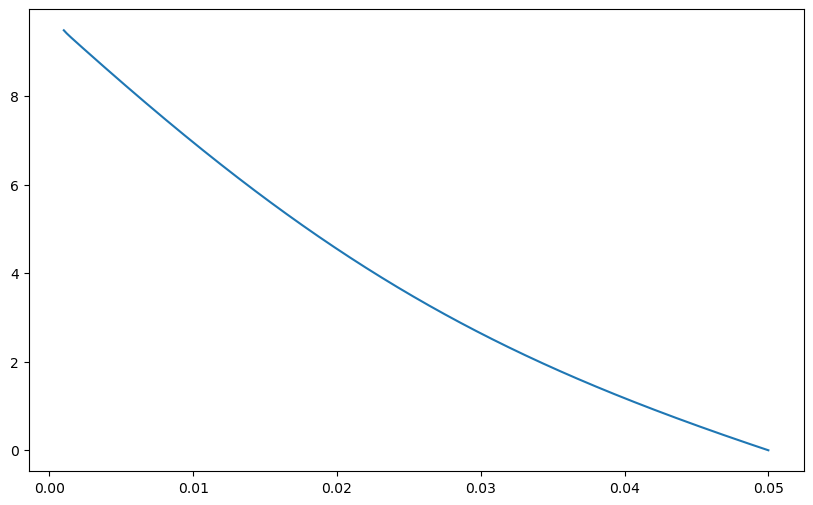

In [34]:
facevalue = 1000
T = 0.5
S = 1
K = 980
dt = 0.01
r = 0.05
sigma = 0.12
k = 0.92
r_mean = 0.055
dr = 0.0001
N = 500

r_grid, S_grid = FDM_CIR(facevalue,r, sigma, k, r_mean, dr, K, S, T, dt,N)

plt.figure(figsize = (10,6))
plt.plot(r_grid[10:], S_grid[10:])
# plt.plot(r_grid[0:], S_grid[0:])
plt.show()

#### Question 4

In [34]:
def G2PP(T,dt,r0,x0,y0, a, b, sigma, eta, phi, rho, n, ret_r_T = False):
    M = int(T/dt)
    #  init df for R
    df_x = pd.DataFrame(np.nan, index=range(n), columns=range(M+1))
    df_y = pd.DataFrame(np.nan, index=range(n), columns=range(M+1))
    df_r = pd.DataFrame(np.nan, index=range(n), columns=range(M+1))

    df_x.iloc[:,0] = x0
    df_y.iloc[:,0] = y0
    df_r.iloc[:,0] = r0
    # loop through  M
    for i in range(1,M+1):
        # simulate Z
        Z1 = np.array(np.random.normal(0,1,size=n)).T
        Z2 = rho*Z1+np.sqrt(1-rho)*np.array(np.random.normal(0,1,size=n)).T

        df_x.iloc[:,i] = -a*dt*df_x.iloc[:,i-1]+sigma*np.sqrt(dt)*Z1
        df_y.iloc[:,i] = -b*dt*df_y.iloc[:,i-1]+eta*np.sqrt(dt)*Z2
        df_r.iloc[:,i] = df_x.iloc[:,i-1]+df_y.iloc[:,i-1]+phi
    # rt*dt
    df_mul = df_r.mul(dt)
    row_sum = df_mul.sum(axis = 1)
    R_mean = np.mean(row_sum)
    
    if ret_r_T:
        return R_mean,np.mean(df_r.iloc[:,M]),np.mean(df_x.iloc[:,M]), np.mean(df_y.iloc[:,M])
    return R_mean

In [22]:
from scipy.stats import multivariate_normal


def G_Model(r0, T, phi, x_i, y_i, rho, a, b, sigma, eta):
    M = int(T/dt)
    r_list = np.zeros(M+1)
    r_list[0] = r0
    for i in range(1,M+1):
        
        z1, z2 = multivariate_normal.rvs([0, 0], [[1, rho], [rho, 1]])
        x_i += - a*x_i*dt + sigma*np.sqrt(dt)*z1
        y_i += - b*y_i*dt + eta*np.sqrt(dt)*z2
        r_i = x_i + y_i + phi
        r_list[i] = r_i
    return r_list,r_i,x_i,y_i

def ZCB_G2PP(facevalue, T, dt, r0, x0, y0, a, b, sigma, eta, phi, rho, n):

    prc = []
    for i in range(n):
        r_list = G_Model(r0, T, phi, x0, y0, rho, a, b, sigma, eta)[0]
        prc_i = np.exp(-np.sum(r_list)*dt)*facevalue
        prc.append(prc_i)

    return np.mean(prc)
    


def EU_Put_ZCB_G2PP(K,T, facevalue, S, dt,r0, x0, y0, a, b, sigma, eta, phi, n_1, n_2):
    # array for value
    Val = np.ones(n_1)
    # fill in values 
    for i in range(n_1):
        r_list, r_T, x_T, y_T =G_Model(r0, T, phi, x0, y0, rho, a, b, sigma, eta)
        R_i = np.sum(r_list)*dt
        # print(R_i, x_T, y_T)
        P_i = ZCB_G2PP(facevalue, S-T, dt, r_T, x_T, y_T, a, b, sigma, eta, phi, rho, n_2)
        #P_i = 1
        # print(P_i)
        Val_i = np.exp(-R_i)*(np.maximum(K-P_i,0))
        Val[i] = Val_i    
    Val_avg = np.mean(Val)
    return Val_avg

facevalue = 1000
x0 = 0
y0 = 0
r0 = 0.055
phi= 0.055
rho = 0.7
a = 0.1
b = 0.3
sigma = 0.05
eta = 0.09
dt = 1/252
T = 0.5
S = 1
K = 950

n_1 = 200
n_2 = 200


EU_Put_ZCB_G2PP(K,T, facevalue, S, dt, r0, x0, y0, a, b, sigma, eta, phi, n_1, n_2)

6.386475813886211

: 

#### Explicit Solution

In [17]:
def Sigma(t, T, S, a, b, sigma, eta,rho):
    Sigma_2 = ((sigma**2/(2*a**3))*(1-np.exp(-a*(S-T)))**2*(1-np.exp(-2*a*(T-t)))+
               ((eta**2)/(2*b**3))*(1-np.exp(-b*(S-T)))**2*(1-np.exp(-2*b*(T-t)))+
               +2*rho*((sigma*eta)/(a*b*(a+b)))*(1-np.exp(-a*(S-T)))*(1-np.exp(-b*(S-T)))*(1-np.exp(-(a+b)*(T-t)))               
    )
    return np.sqrt(Sigma_2)
def P(t, T, phi, a, b, xt, yt, V):
    val = np.exp(-(T-t)*phi-
                  (1-np.exp(-a*(T-t)))*xt/a-
                  (1-np.exp(-b*(T-t)))*yt/b+
                  0.5*V)
    return val
def V(t, T, a, b, sigma, eta,rho):
    val = (
        ((sigma**2)/(a**2))*(T-t+(2/a)*np.exp(-a*(T-t))-(1/(2*a))*np.exp(-2*a*(T-t))-(3/(2*a)))+
        ((eta**2)/(b**2))*(T-t+(2/b)*np.exp(-b*(T-t))-(1/(2*b))*np.exp(-2*b*(T-t))-(3/(2*b)))+
        2*rho*((sigma*eta)/(a*b))*(T-t+((np.exp(-a*(T-t))-1)/a)+((np.exp(-b*(T-t))-1)/b)-((np.exp(-(a+b)*(T-t))-1)/(a+b)))
    )
    return val
def put_G2PP(t, T, S, K, Sigma, P_T,P_S):
    val = (
        -P_S*norm.cdf(np.log(K*P_T/P_S)/Sigma-0.5*Sigma)+P_T*K*norm.cdf(np.log(K*P_T/P_S)/Sigma+0.5*Sigma)
    )
    return val


x0 = 0
y0 = 0
phi= 0.055
rho = 0.7
a = 0.1
b = 0.3
sigma = 0.05
eta = 0.09
t = 0
T = 0.5
S = 1
K = 0.95

V_S = V(t, S, a, b, sigma, eta,rho)
V_T = V(t, T, a, b, sigma, eta,rho)
Sigma_ = Sigma(t, T, S, a, b, sigma, eta,rho)
P_S = P(t, S, phi, a, b, x0, y0, V_S)
P_T = P(t, T, phi, a, b, x0, y0, V_T)

1000*put_G2PP(t, T, S, K, Sigma_, P_T,P_S)


    

6.171630652332172

In [20]:
rho_list = np.arange(-0.7, 0.8, 0.1)
result_list_1 = []
result_list_2 = []

for rho in rho_list:
    V_S = V(t, S, a, b, sigma, eta,rho)
    V_T = V(t, T, a, b, sigma, eta,rho)
    Sigma_ = Sigma(t, T, S, a, b, sigma, eta,rho)
    P_S = P(t, S, phi, a, b, x0, y0, V_S)
    P_T = P(t, T, phi, a, b, x0, y0, V_T)

    result_list_1.append(1000*put_G2PP(t, T, S, K, Sigma_, P_T,P_S))
    #result_list_2.append(EU_Put_ZCB_G2PP(K,T, facevalue, S, dt, r0, x0, y0, a, b, sigma, eta, phi, n_1, n_2))
    

    

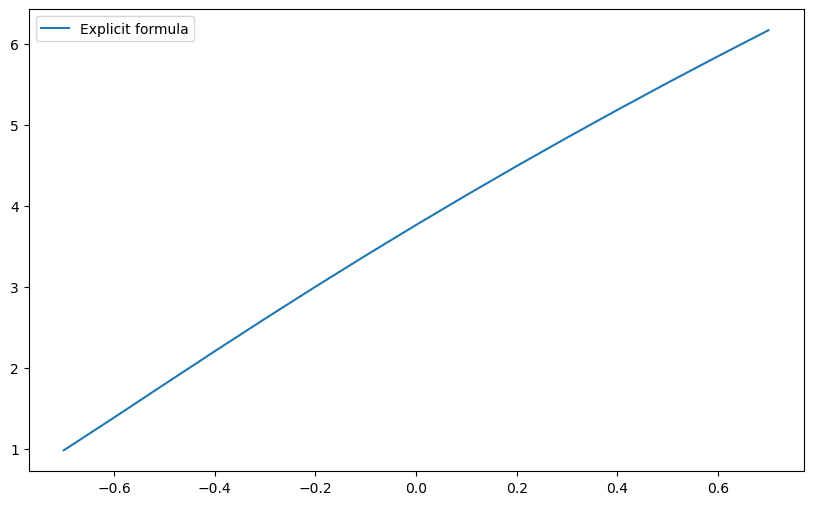

In [21]:
plt.figure(figsize = (10,6))
plt.plot(rho_list, result_list_1, label = 'Explicit formula')
#plt.plot(rho_list, result_list_2, label = 'Monte Carlo')
plt.legend()
plt.show()

#### Question 5

In [22]:
def CIR_R(T,dt = 1/12,r0 = 0.078,sigma = 0.12,k = 0.6,r_mean = 0.08, n = 1000):
    M = int(T/dt)
    #  init df for R
    df = pd.DataFrame(np.nan, index=range(n), columns=range(M+1))
    # fill in r_0
    df.iloc[:,0] = r0
    # loop through  M
    for i in range(1,M+1):
        # simulate Z
        Z = np.array(np.random.normal(0,1,size=n)).T
        # df.iloc[:,i] = np.maximum((df.iloc[:,i-1]+k*(r_mean- df.iloc[:,i-1])*dt+sigma*np.sqrt(df.iloc[:,i-1])*np.sqrt(dt)*Z),0)
        df.iloc[:,i] = np.abs(df.iloc[:,i-1]+k*(r_mean- df.iloc[:,i-1])*dt+sigma*np.sqrt(df.iloc[:,i-1])*np.sqrt(dt)*Z)
    return df

def P( T = 30, R = 0.08, dt = 1/12, P0 = 100000, n = 1000):
    r_interest = R/12
    M = int(T/dt)
    N = M
    # rmatrix is n*M
    # 40 Yrs matrix for r_t_10
    r_matrix_40 = CIR_R(T+10)
    r_matrix = r_matrix_40.iloc[:,:30*12+1].copy()
    
    # calculate dt
    dt_matrix = r_matrix.iloc[:,1:].copy()*dt
    dt_matrix = dt_matrix.cumsum(axis = 1)
    dt_matrix = np.exp(-dt_matrix)
         
    # calculate CPR, PV, IO, PO
    CPR_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(M))
    PV_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(M+1))
    IO_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(M))
    PO_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(M))
    ct_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(M))
    # fill P_matrix
    PV_matrix.iloc[:,0] = P0
    
    # dictionary for SY
    SY_values = [0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98]
    months = [1,2,3,4,5,6,7,8,9,10,11,0]
    SY_dic = {month: value for month, value in zip(months, SY_values)}
    
    PMT = P0 * r_interest / (1 - (1 + r_interest) **(-N))
    for i in range(M):
        t = i+1
        
        Month = t%12
        PV_t_1 = PV_matrix.iloc[:,t-1]
        # SY
        SY_t = SY_dic[Month]
        # SG
        SG_t = np.minimum(1,t/30)
        # BU
        BU_t = 0.3+0.7*PV_t_1/P0
        # RI
        end_time = i+10*12+1
        r_matrix_r_10 = r_matrix_40.iloc[:,i:end_time].copy()
        r_matrix_r_10 = r_matrix_r_10*dt
        r_t_10 = r_matrix_r_10.sum(axis = 1)/10
        # print(r_t_10)
        RI_t = 0.28+0.14*np.arctan(-8.57+430*(R-r_t_10))
        CPR_matrix.iloc[:,i] = SY_t*SG_t*BU_t*RI_t
        IP = PV_t_1*r_interest
        MP = (PV_t_1*r_interest)/(1-(1/((1+r_interest)**(N-t+1))))
        SP = MP-IP
        PP = (PV_t_1-SP)*(1-(1-CPR_matrix.iloc[:,i])**(1/12))
        TPP = SP+PP
        # TPP = PV_t_1*r_interest*(1/(1-(1+r_interest)**(-N+t-1))-1) + (PV_t_1 - PV_t_1*r_interest*(1/(1-(1+r_interest)**(-N+t-1))-1))*(1-(1-CPR_matrix.iloc[:,i])**(1/12))
        PV_t = PV_t_1 - TPP
        ct = SP+PP+IP
        PV_matrix.iloc[:,t] = PV_t
        IO_matrix.iloc[:,i] = IP
        PO_matrix.iloc[:,i] = TPP
        ct_matrix.iloc[:,i] = ct


    # calculate p
    ct_dt_matrix = ct_matrix*dt_matrix
    rowsum_ct_dt = ct_dt_matrix.sum(axis = 1)
    prc = np.mean(rowsum_ct_dt)
    # PO and IO
    PO_dt_matrix = PO_matrix*dt_matrix
    IO_dt_matrix = IO_matrix*dt_matrix
    PO = np.mean(PO_dt_matrix.sum(axis = 1))
    IO = np.mean(IO_dt_matrix.sum(axis = 1))
    
    return prc
    
T = 30
R = 0.08
P0 = 100000
dt = 1/12
# n = 10000
P()
    


99943.38340580663

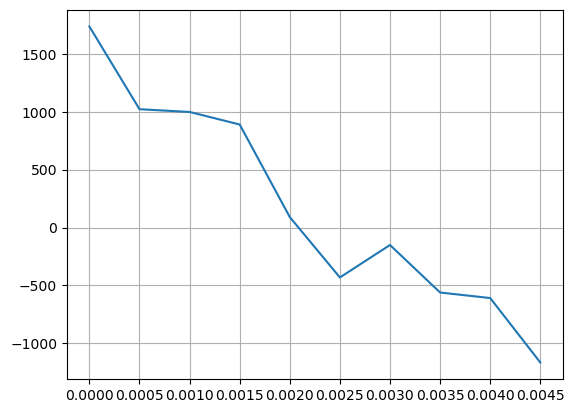

In [20]:
def P(spread, target = 98000, T = 30, R = 0.08, dt = 1/12, P0 = 100000, n = 1000):
    r_interest = R/12
    M = int(T/dt)
    N = M
    # rmatrix is n*M
    # 40 Yrs matrix for r_t_10
    r_matrix_40 = CIR_R(T+10)
    r_matrix_40 = r_matrix_40+spread
    r_matrix = r_matrix_40.iloc[:,:30*12+1].copy()
    
    # calculate dt
    dt_matrix = r_matrix.iloc[:,1:].copy()*dt
    dt_matrix = dt_matrix.cumsum(axis = 1)
    dt_matrix = np.exp(-dt_matrix)
         
    # calculate CPR, PV
    CPR_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(M))
    PV_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(M+1))
    ct_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(M))
    # fill P_matrix
    PV_matrix.iloc[:,0] = P0
    
    # dictionary for SY
    SY_values = [0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98]
    months = [1,2,3,4,5,6,7,8,9,10,11,0]
    SY_dic = {month: value for month, value in zip(months, SY_values)}
    
    for i in range(M):
        t = i+1
        
        Month = t%12
        PV_t_1 = PV_matrix.iloc[:,t-1]
        # SY
        SY_t = SY_dic[Month]
        # SG
        SG_t = np.minimum(1,t/30)
        # BU
        BU_t = 0.3+0.7*PV_t_1/P0
        # RI
        end_time = i+10*12+1
        r_matrix_r_10 = r_matrix_40.iloc[:,i:end_time].copy()
        r_matrix_r_10 = r_matrix_r_10*dt
        r_t_10 = r_matrix_r_10.sum(axis = 1)/10
        # print(r_t_10)
        RI_t = 0.28+0.14*np.arctan(-8.57+430*(R-r_t_10))
        CPR_matrix.iloc[:,i] = SY_t*SG_t*BU_t*RI_t
        IP = PV_t_1*r_interest
        MP = (PV_t_1*r_interest)/(1-(1/((1+r_interest)**(N-t+1))))
        SP = MP-IP
        PP = (PV_t_1-SP)*(1-(1-CPR_matrix.iloc[:,i])**(1/12))
        TPP = SP+PP
        # TPP = PV_t_1*r_interest*(1/(1-(1+r_interest)**(-N+t-1))-1) + (PV_t_1 - PV_t_1*r_interest*(1/(1-(1+r_interest)**(-N+t-1))-1))*(1-(1-CPR_matrix.iloc[:,i])**(1/12))
        PV_t = PV_t_1 - TPP
        ct = SP+PP+IP
        
        TPP = PV_t_1*r_interest*(1/(1-(1+r_interest)**(-N+t-1))-1) + (PV_t_1 - PV_t_1*r_interest*(1/(1-(1+r_interest)**(-N+t-1))-1))*(1-(1-CPR_matrix.iloc[:,i])**(1/12))
        PV_t = PV_t_1 - TPP
        PV_matrix.iloc[:,t] = PV_t
        ct_matrix.iloc[:,i] = ct

    # calculate p
    ct_dt_matrix = ct_matrix*dt_matrix
    rowsum_ct_dt = ct_dt_matrix.sum(axis = 1)
    prc = np.mean(rowsum_ct_dt)
    return prc-target

result = []
i_list = []
for i in np.arange(0.00, 0.005, 0.0005):
    result.append(P(i))
    i_list.append(i)

plt.plot(i_list, result)
plt.xticks(i_list)
plt.grid()
plt.show()

spread = 0.0025

In [25]:
def P( T = 30, R = 0.08, dt = 1/12, P0 = 100000, n = 1000, r_mean_  = 0.08):
    r_interest = R/12
    M = int(T/dt)
    N = M
    # rmatrix is n*M
    # 40 Yrs matrix for r_t_10
    r_matrix_40 = CIR_R(T+10,r_mean=r_mean_)
    r_matrix = r_matrix_40.iloc[:,:30*12+1].copy()
    
    # calculate dt
    dt_matrix = r_matrix.iloc[:,1:].copy()*dt
    dt_matrix = dt_matrix.cumsum(axis = 1)
    dt_matrix = np.exp(-dt_matrix)
         
    # calculate CPR, PV, IO, PO
    CPR_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(M))
    PV_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(M+1))
    IO_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(M))
    PO_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(M))
    ct_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(M))
    # fill P_matrix
    PV_matrix.iloc[:,0] = P0
    
    # dictionary for SY
    SY_values = [0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98]
    months = [1,2,3,4,5,6,7,8,9,10,11,0]
    SY_dic = {month: value for month, value in zip(months, SY_values)}

    for i in range(M):
        t = i+1
        
        Month = t%12
        PV_t_1 = PV_matrix.iloc[:,t-1]
        # SY
        SY_t = SY_dic[Month]
        # SG
        SG_t = np.minimum(1,t/30)
        # BU
        BU_t = 0.3+0.7*PV_t_1/P0
        # RI
        end_time = i+10*12+1
        r_matrix_r_10 = r_matrix_40.iloc[:,i:end_time].copy()
        r_matrix_r_10 = r_matrix_r_10*dt
        r_t_10 = r_matrix_r_10.sum(axis = 1)/10
        # print(r_t_10)
        RI_t = 0.28+0.14*np.arctan(-8.57+430*(R-r_t_10))
        CPR_matrix.iloc[:,i] = SY_t*SG_t*BU_t*RI_t
        IP = PV_t_1*r_interest
        MP = (PV_t_1*r_interest)/(1-(1/((1+r_interest)**(N-t+1))))
        SP = MP-IP
        PP = (PV_t_1-SP)*(1-(1-CPR_matrix.iloc[:,i])**(1/12))
        TPP = SP+PP
        # TPP = PV_t_1*r_interest*(1/(1-(1+r_interest)**(-N+t-1))-1) + (PV_t_1 - PV_t_1*r_interest*(1/(1-(1+r_interest)**(-N+t-1))-1))*(1-(1-CPR_matrix.iloc[:,i])**(1/12))
        PV_t = PV_t_1 - TPP
        ct = SP+PP+IP
        PV_matrix.iloc[:,t] = PV_t
        IO_matrix.iloc[:,i] = IP
        PO_matrix.iloc[:,i] = TPP
        ct_matrix.iloc[:,i] = ct


    # calculate p
    ct_dt_matrix = ct_matrix*dt_matrix
    rowsum_ct_dt = ct_dt_matrix.sum(axis = 1)
    prc = np.mean(rowsum_ct_dt)
    # PO and IO
    PO_dt_matrix = PO_matrix*dt_matrix
    IO_dt_matrix = IO_matrix*dt_matrix
    PO = np.mean(PO_dt_matrix.sum(axis = 1))
    IO = np.mean(IO_dt_matrix.sum(axis = 1))
    
    return prc, PO, IO

prc, PO, IO = P()
print(f'Total Price: {prc}')
print(f'PO Price: {PO}')
print(f'IO Price: {IO}')

Total Price: 99295.64201782331
PO Price: 50643.16733627264
IO Price: 48652.47468155065


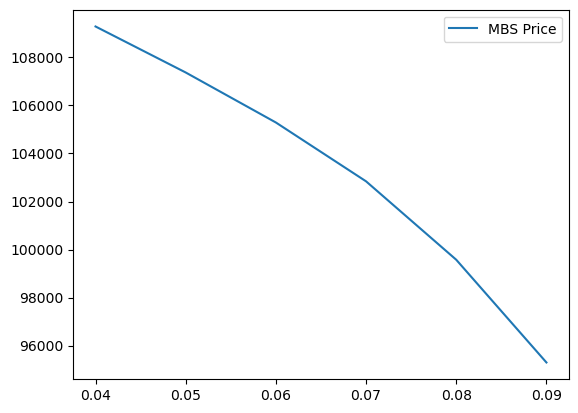

[109289.52725501286,
 107373.31198797574,
 105290.65049364381,
 102840.0536681987,
 99574.38756305155,
 95296.21787714637]

In [35]:
r_list = np.arange(0.04, 0.1, 0.01)
prc = []
for r_mean in r_list:
    prc.append(P(r_mean_ = r_mean)[0])
    
plt.plot(r_list,prc,label = 'MBS Price')
plt.legend()
plt.show()
prc

